In [1]:
#for retreiving the correct data file
import glob

# for data structures and tools
import numpy as np
import pandas as pd

#for plotting
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#for some analyses
from scipy import stats
from scipy.signal import butter, filtfilt, freqz

# for interactive plots
import plotly.tools as pt
pt.set_credentials_file(username='sleepandcognitionlab', api_key='l9O6wZNzv8FJFydIwjRt')
import plotly.plotly as py
import cufflinks as cf
import plotly.graph_objs as go

import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics 
from sklearn.metrics import classification_report

In [2]:
base_path = '../../Data/Word Pair Analysis Output'

merge_list = []

for pNum in range(1, 20):
    try:
        merge_list.append(pd.DataFrame.from_csv(base_path + '/%02dIceProcessed.csv' %pNum, index_col=None, encoding = "ISO-8859-1"))
    except OSError:
        pass

merged_df = pd.concat(merge_list)
merged_df.drop([col for col in merged_df.columns.tolist() if col[-1] == '1'], axis=1, inplace=True)

In [3]:
cleanBaseline = merged_df.loc[merged_df['baselineQuality'] >= .75,].copy()
cleanPost = merged_df.loc[merged_df['postStimQuality'] >= .75,].copy()
cleanPost.columns

Index(['english', 'baselineZMean', 'postStimZMean', 'baselineXMean',
       'baselineYMean', 'postStimXMean', 'postStimYMean', 'baselineQuality',
       'postStimQuality', 'peakResp', 'slopeResp', 'icelandic_train',
       'englishResponse_train', 'correct_train', 'totalTime_train',
       'englishResponse_test', 'correct_test', 'totalTime_test', 'participant',
       'learnPosition'],
      dtype='object')

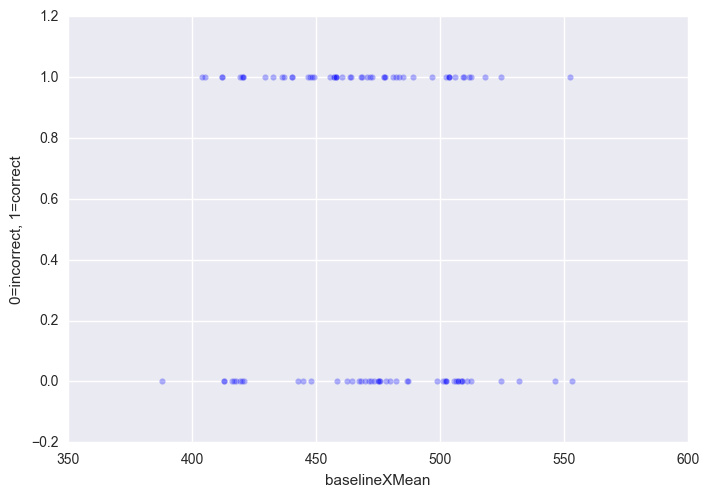

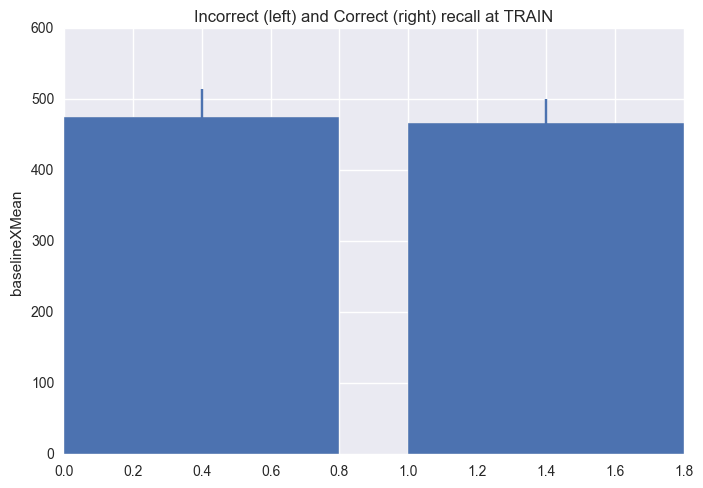

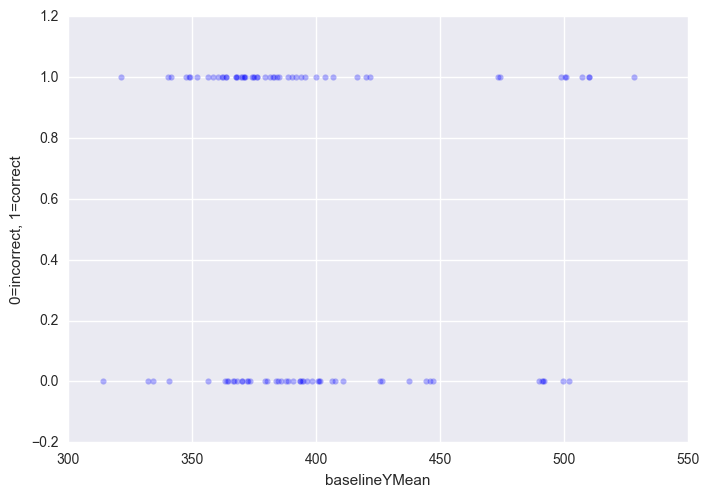

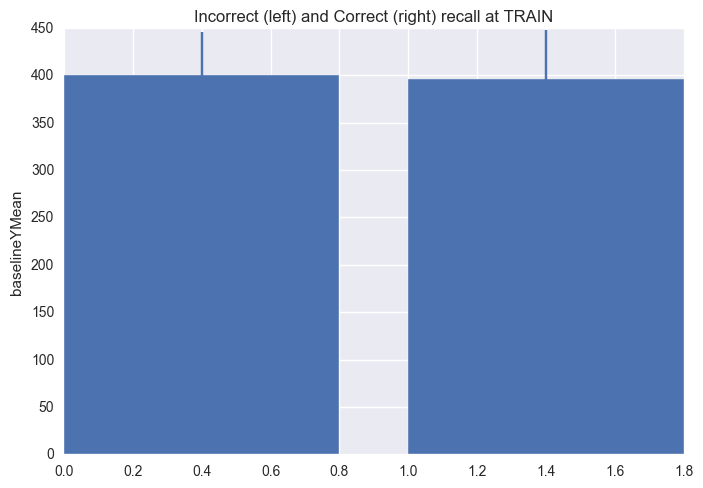

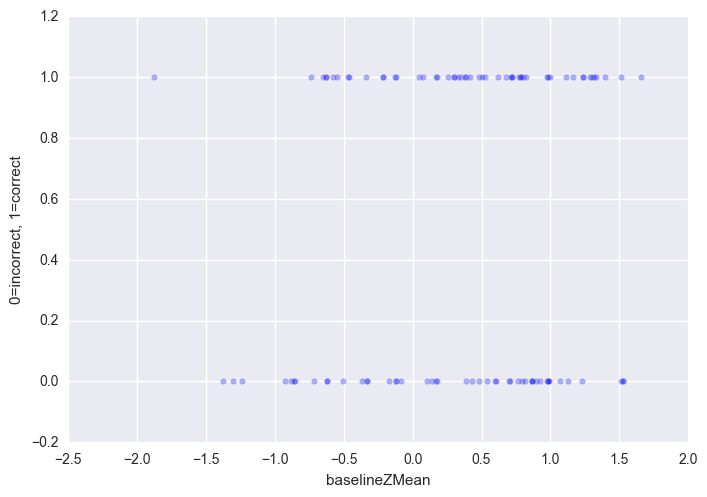

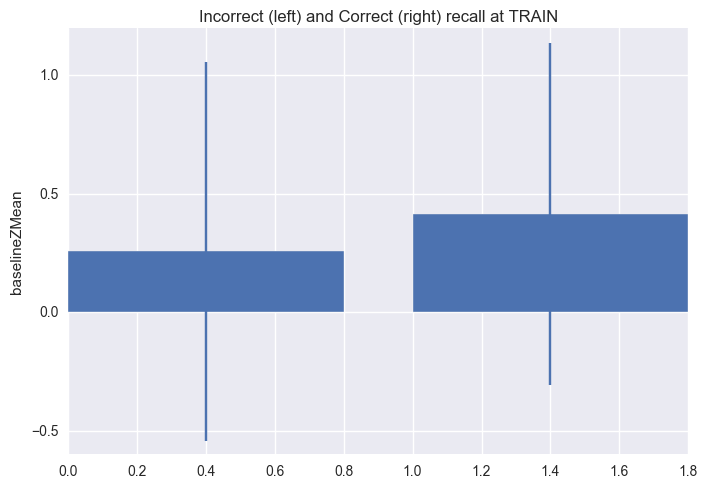

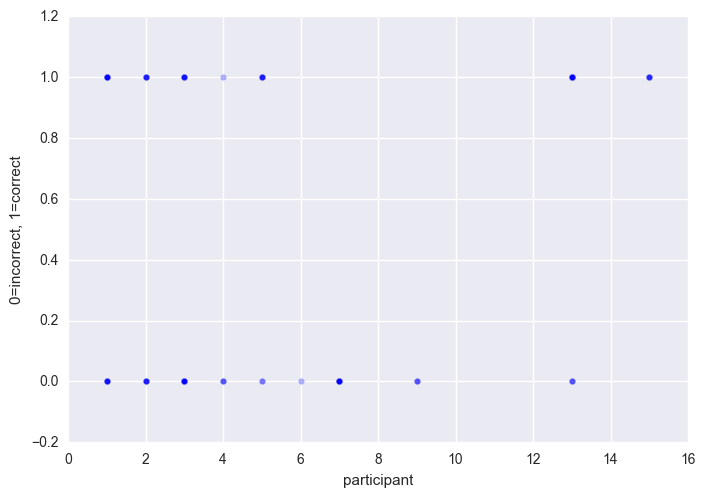

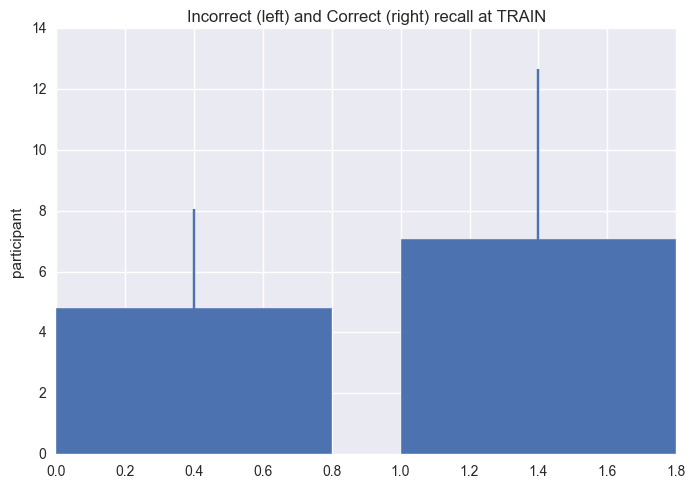

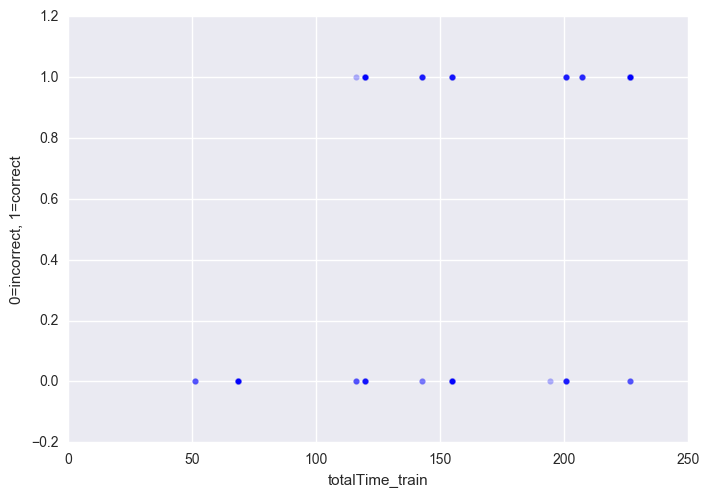

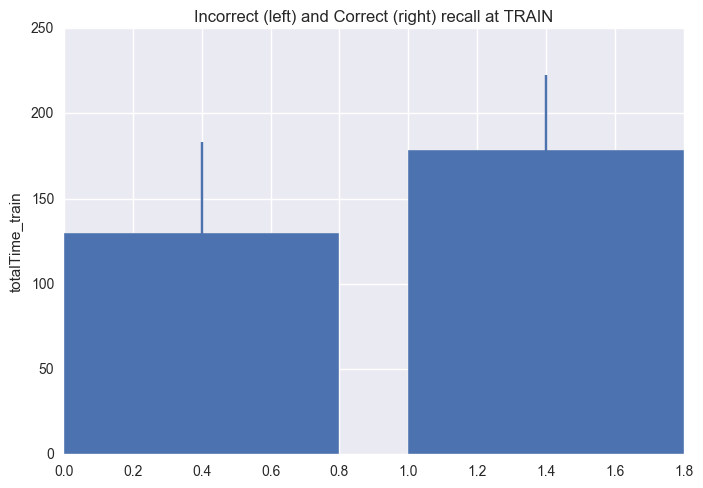

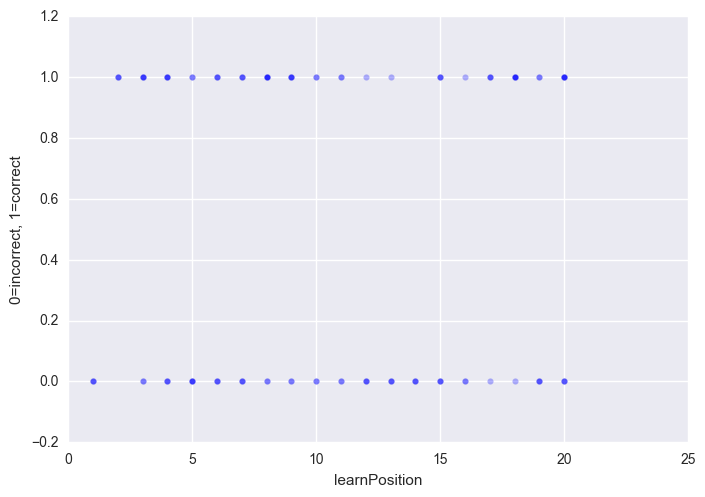

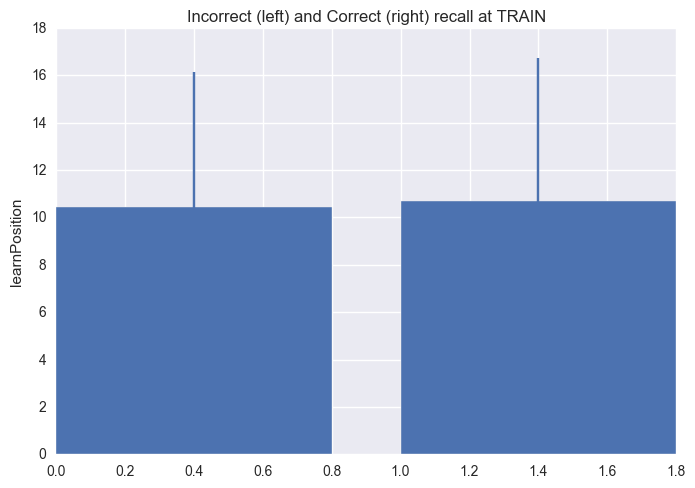

In [38]:
baseline_cols = ['baselineXMean', 'baselineYMean', 'baselineZMean', 'participant', 'totalTime_train', 'learnPosition']
post_cols = ['participant', 'peakResp', 'postStimXMean', 'postStimYMean',
               'postStimZMean', 'slopeResp', 'totalTime_train', 'learnPosition']
for col in baseline_cols:
    plt.figure()
    plt.scatter(cleanBaseline.loc[:,col], cleanBaseline.loc[:,'correct_train'], alpha=.3)#facecolors='none', edgecolors='r')
    plt.xlabel(col)
    plt.ylabel('0=incorrect, 1=correct')
    
    fig, ax = plt.subplots()
    meanWrong = cleanBaseline.loc[cleanBaseline['correct_train'] == 0, col].mean()
    stdWrong = cleanBaseline.loc[cleanBaseline['correct_train'] == 0, col].std()
    meanRight = cleanBaseline.loc[cleanBaseline['correct_train'] == 1, col].mean()
    stdRight = cleanBaseline.loc[cleanBaseline['correct_train'] == 1, col].std()
    ax.bar(range(2),[meanWrong, meanRight], yerr=[stdWrong, stdRight])
    ax.set_ylabel(col)
    ax.set_title("Incorrect (left) and Correct (right) recall at TRAIN")
    #ax.set_xticklabels(('incorrect', 'correct'))

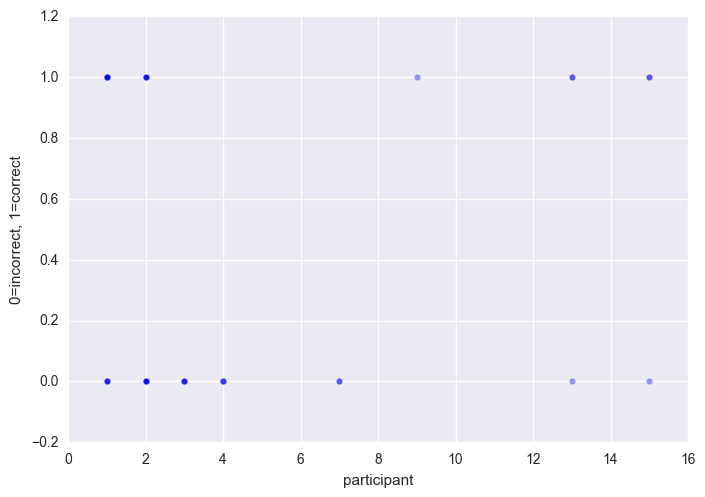

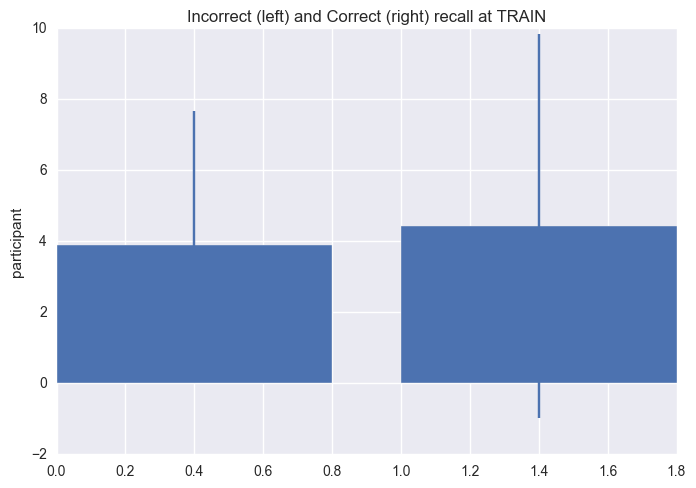

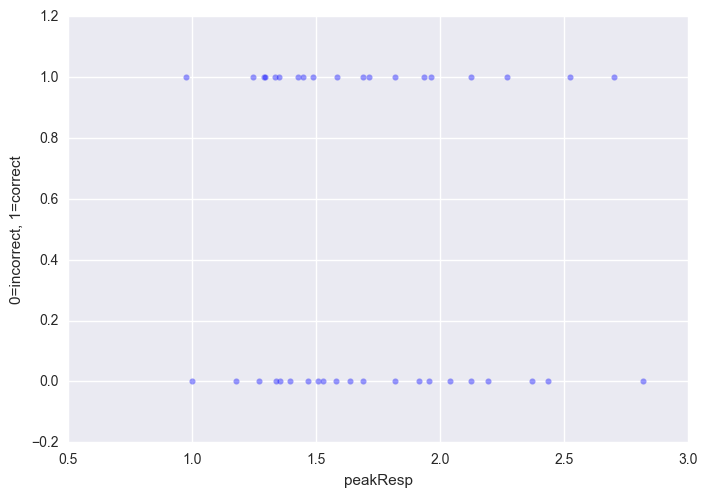

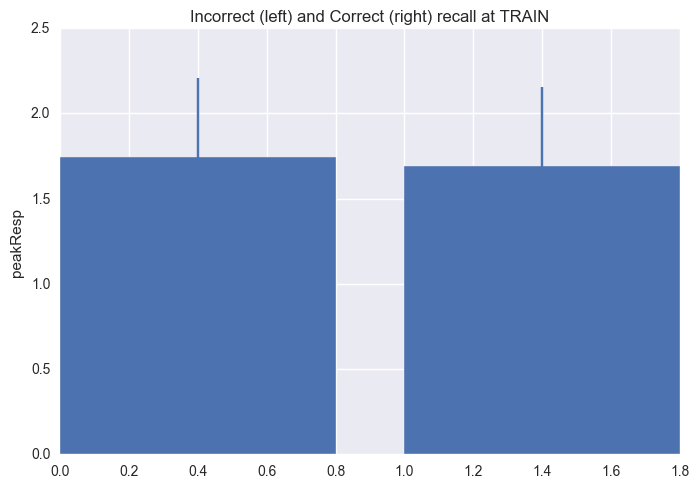

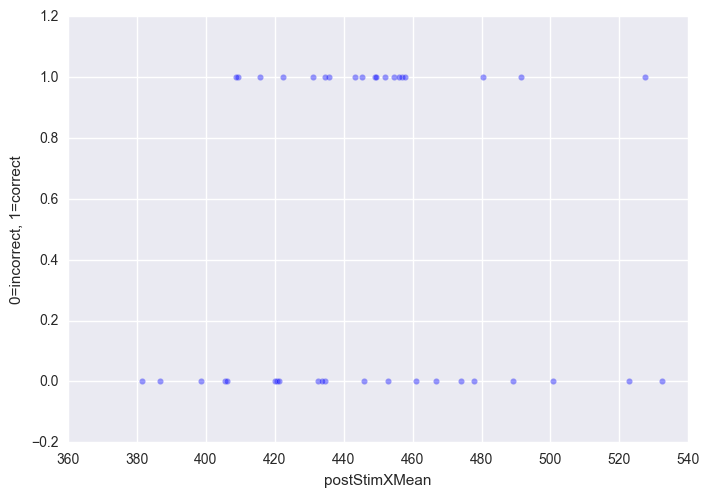

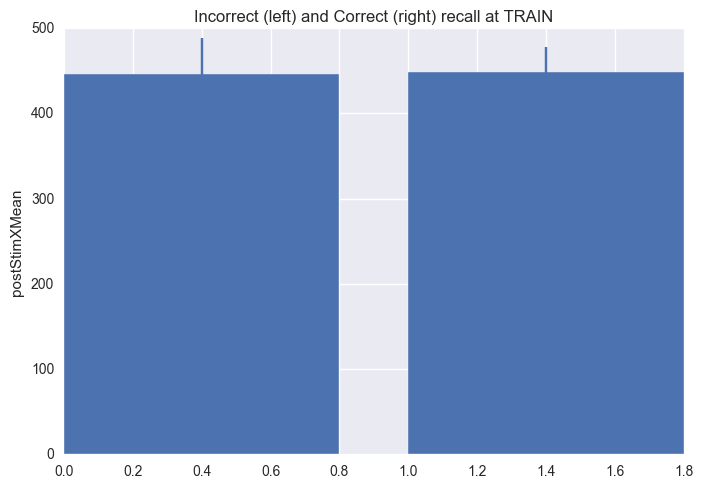

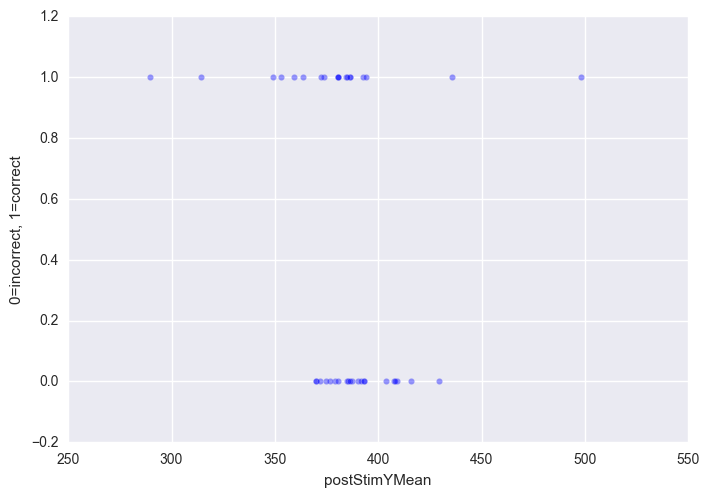

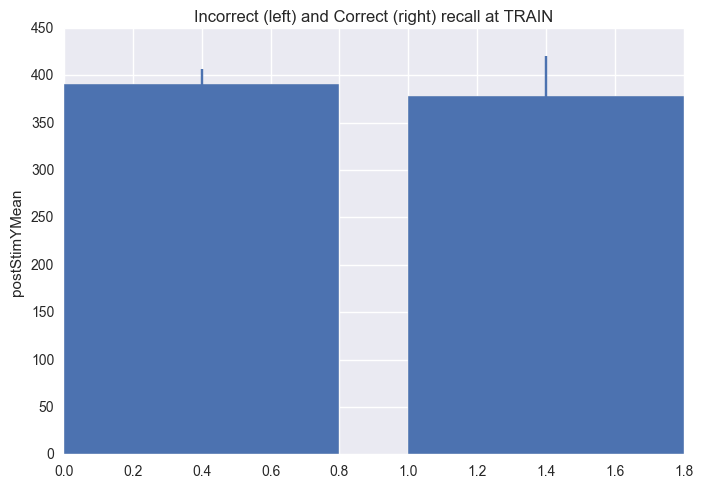

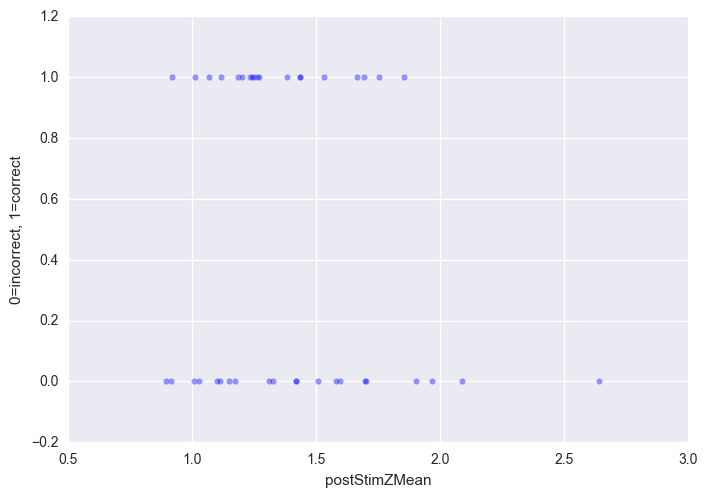

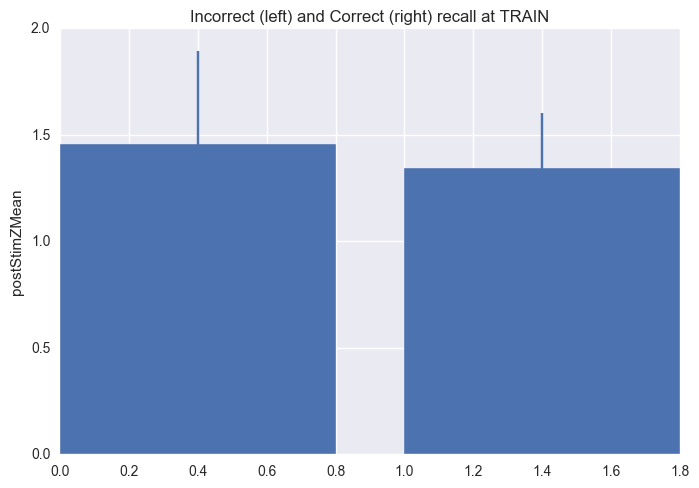

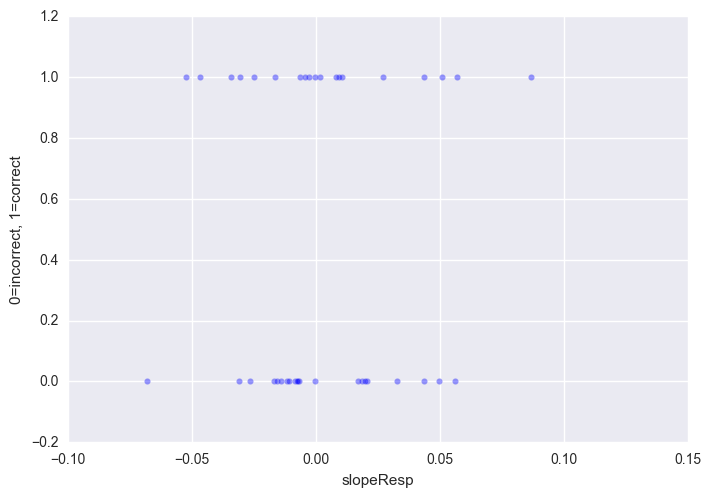

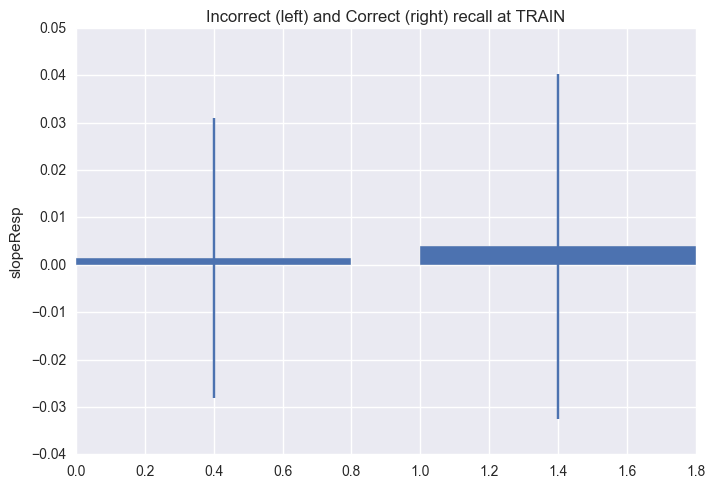

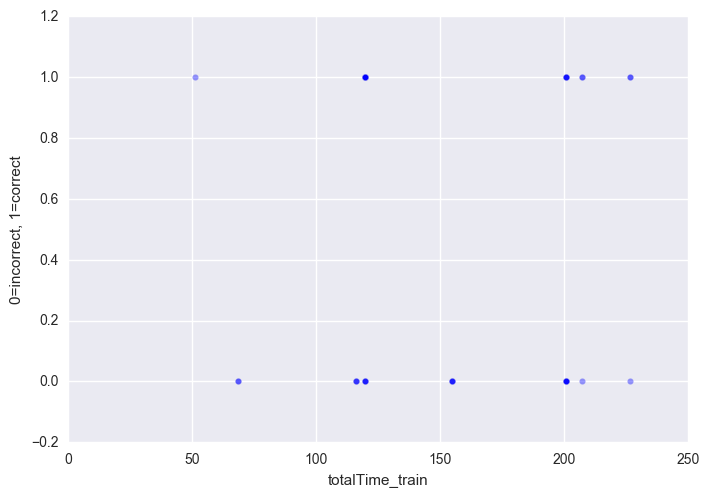

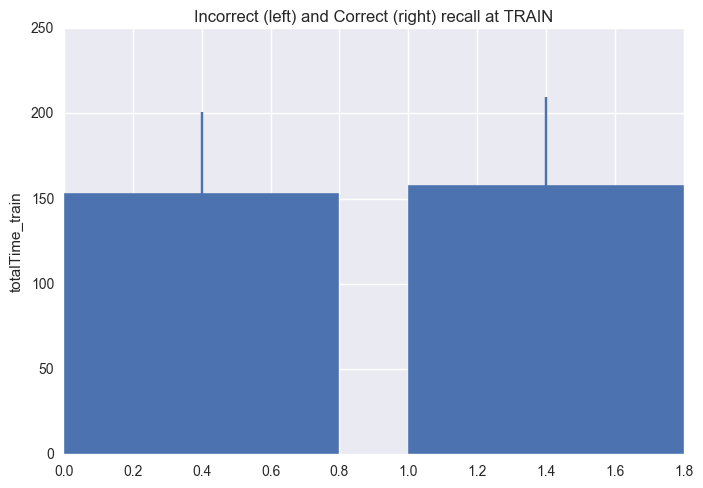

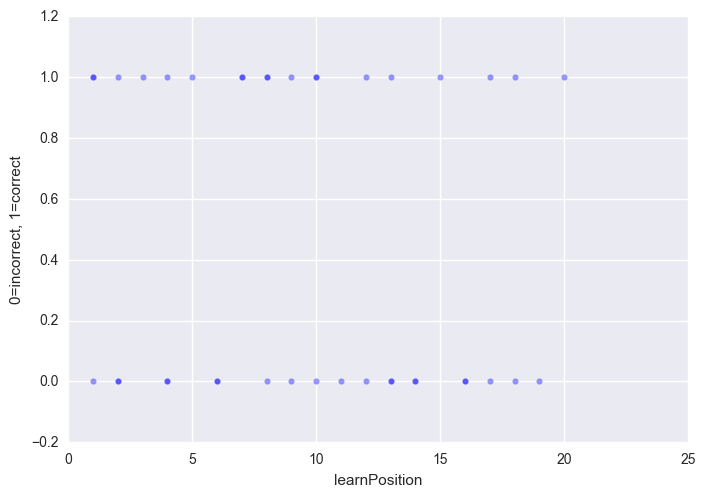

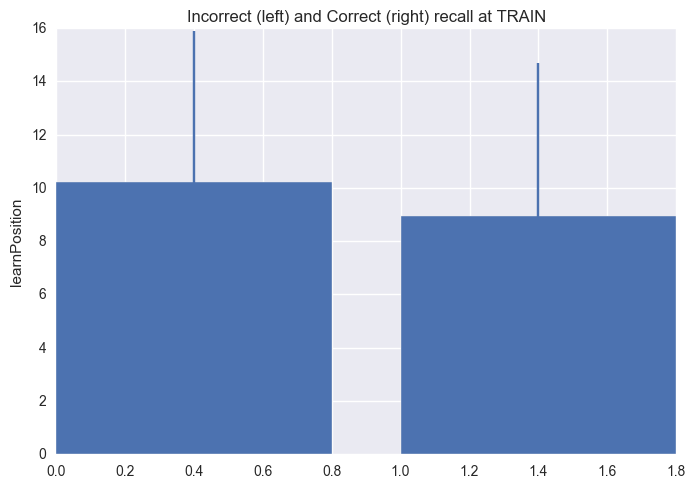

In [39]:
for col in post_cols:
    plt.figure()
    plt.scatter(cleanPost.loc[:,col], cleanPost.loc[:,'correct_train'],alpha=.4)# facecolors='none', edgecolors='r')
    plt.xlabel(col)
    plt.ylabel('0=incorrect, 1=correct')
    
    fig, ax = plt.subplots()
    meanWrong = cleanPost.loc[cleanPost['correct_train'] == 0, col].mean()
    stdWrong = cleanPost.loc[cleanPost['correct_train'] == 0, col].std()
    meanRight = cleanPost.loc[cleanPost['correct_train'] == 1, col].mean()
    stdRight = cleanPost.loc[cleanPost['correct_train'] == 1, col].std()
    ax.bar(range(2),[meanWrong, meanRight], yerr=[stdWrong, stdRight])
    ax.set_ylabel(col)
    ax.set_title("Incorrect (left) and Correct (right) recall at TRAIN")

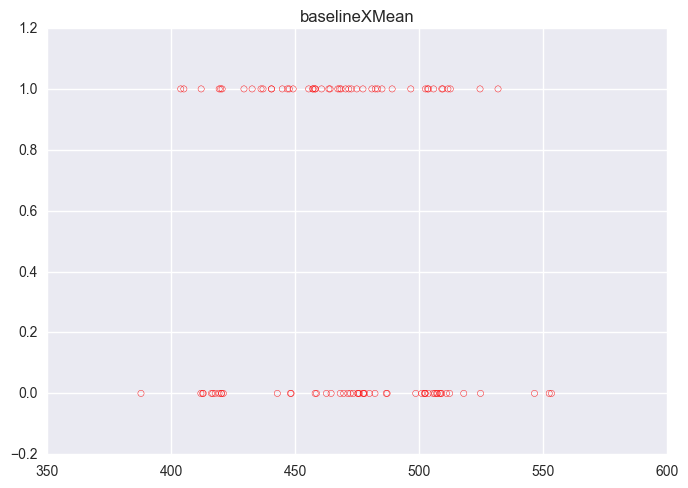

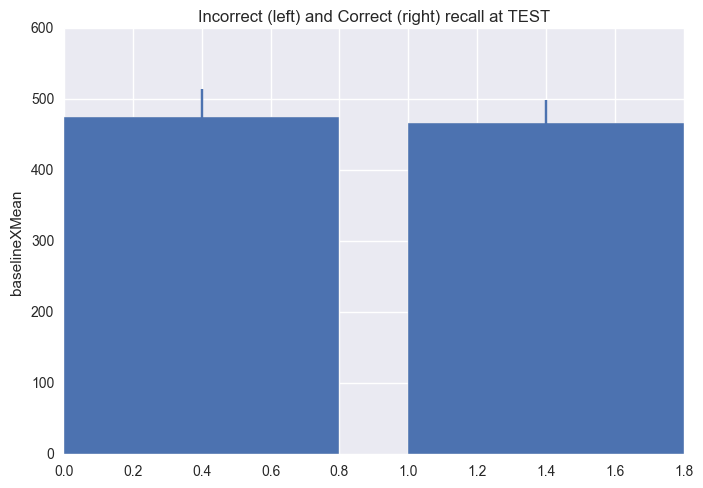

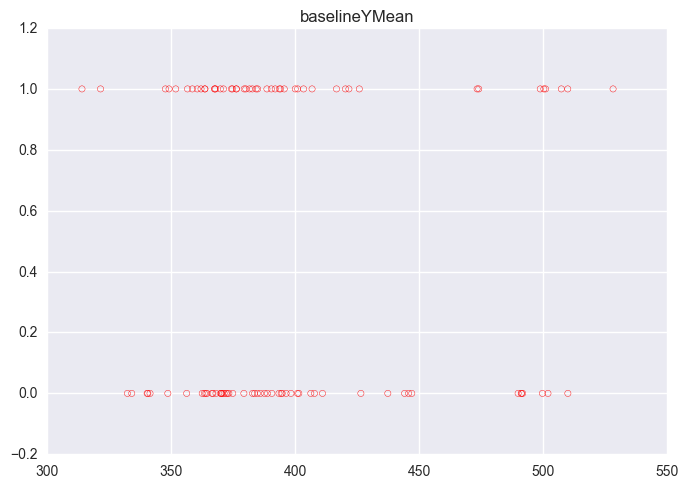

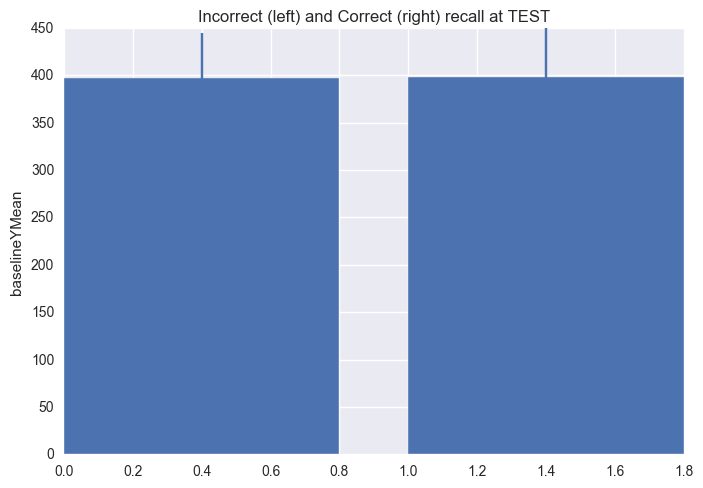

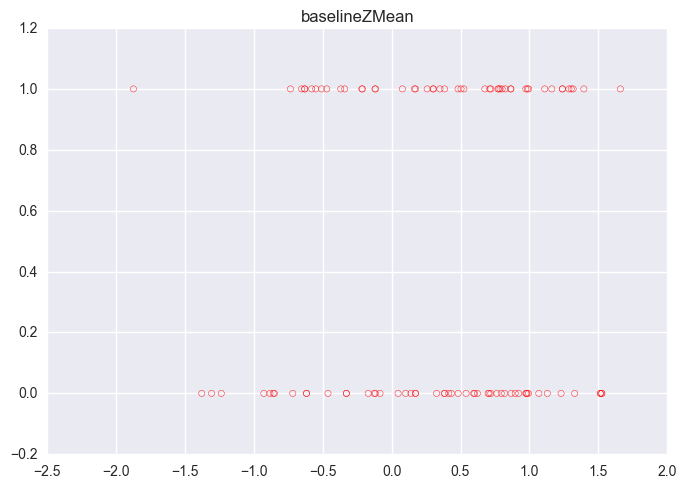

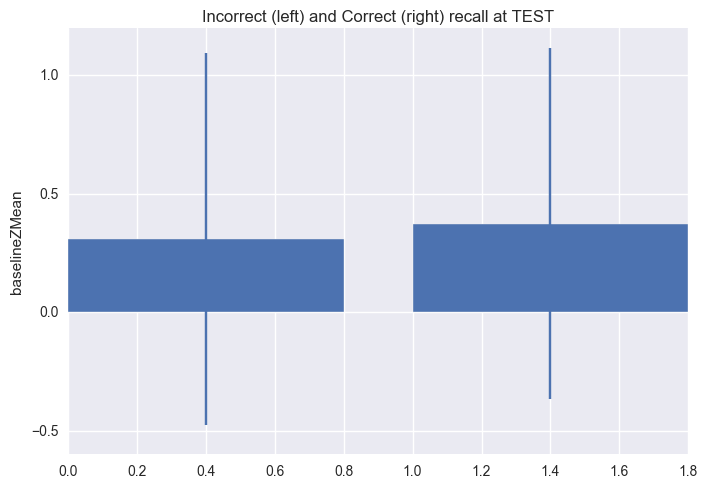

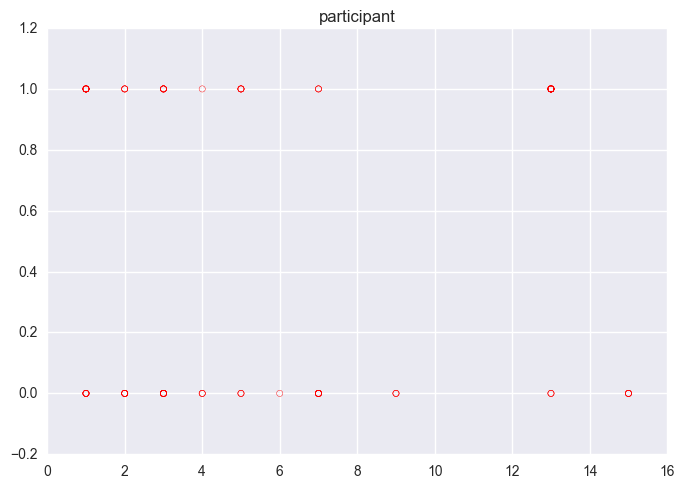

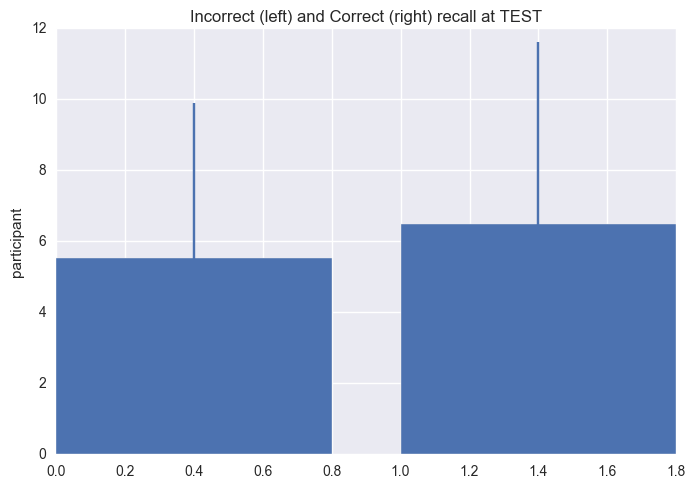

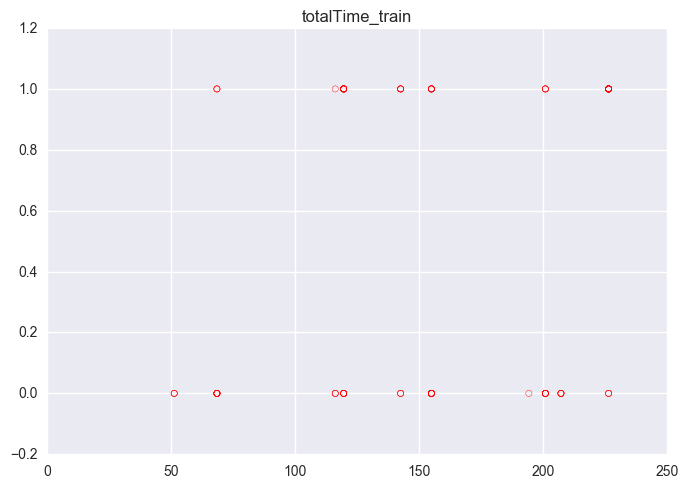

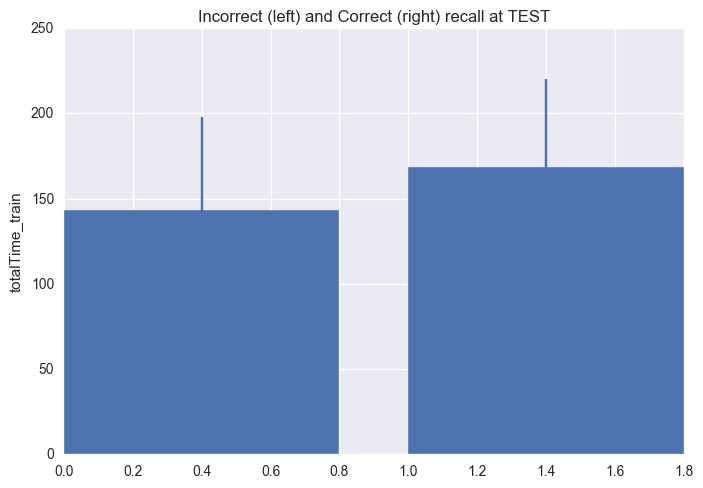

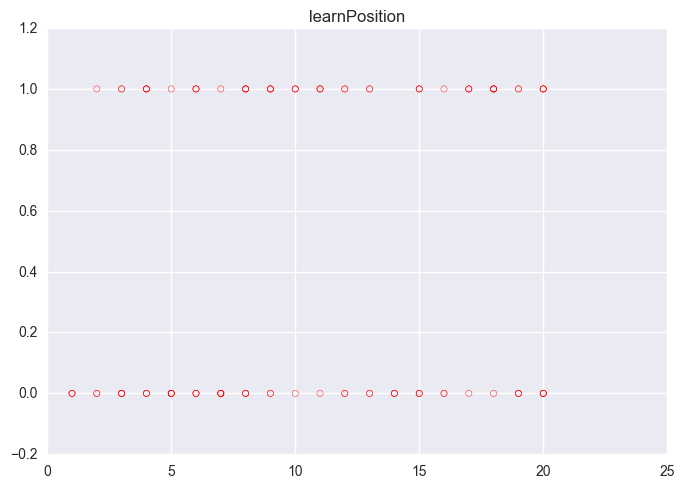

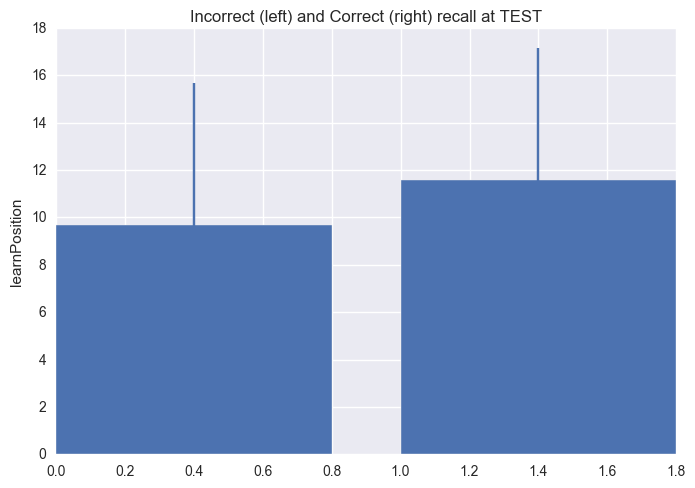

In [40]:
for col in baseline_cols:
    plt.figure()
    plt.scatter(cleanBaseline.loc[:,col], cleanBaseline.loc[:,'correct_test'], facecolors='none', edgecolors='r')
    plt.title(col)
    
    fig, ax = plt.subplots()
    meanWrong = cleanBaseline.loc[cleanBaseline['correct_test'] == 0, col].mean()
    stdWrong = cleanBaseline.loc[cleanBaseline['correct_test'] == 0, col].std()
    meanRight = cleanBaseline.loc[cleanBaseline['correct_test'] == 1, col].mean()
    stdRight = cleanBaseline.loc[cleanBaseline['correct_test'] == 1, col].std()
    ax.bar(range(2),[meanWrong, meanRight], yerr=[stdWrong, stdRight])
    ax.set_ylabel(col)
    ax.set_title("Incorrect (left) and Correct (right) recall at TEST")
    #ax.set_xticklabels(('incorrect', 'correct'))

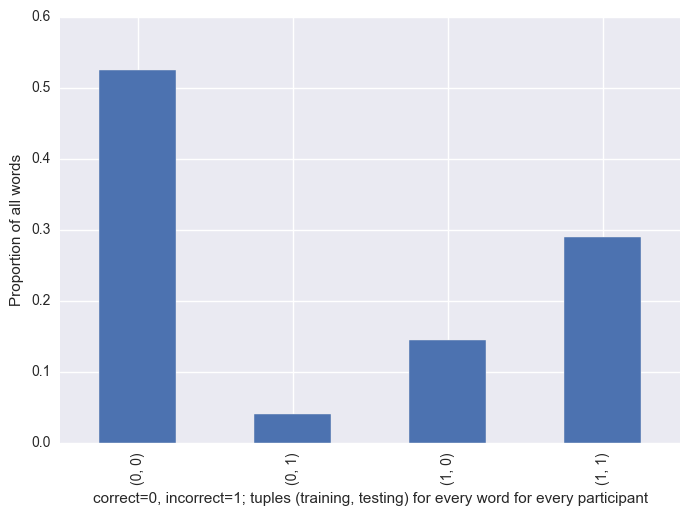

In [10]:
total_words = merged_df.shape[0]
(merged_df.groupby(['correct_train', 'correct_test']).size() / total_words).plot(kind='bar')
plt.ylabel('Proportion of all words')
plt.xlabel('correct=0, incorrect=1; tuples (training, testing) for every word for every participant')

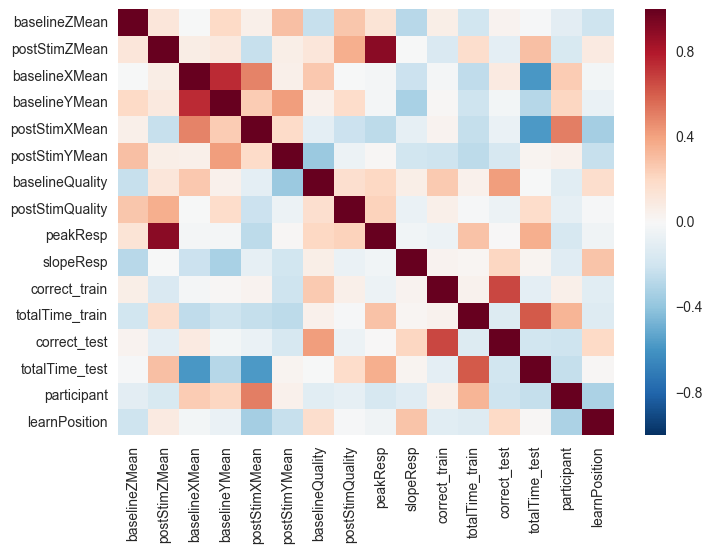

In [6]:
sb.heatmap(cleanPost.corr())

In [216]:
# try: cleanBaseline.drop(['baselineYMean', 'participant', 'peakResp', 'postStimQuality', 'postStimXMean',
#                    'postStimYMean', 'postStimZMean', 'baselineQuality', 'english', 'englishResponse_test', 
#                          'englishResponse_train', 'icelandic_train'], axis=1, inplace=True)
# except:
#     pass
# sb.heatmap(cleanBaseline.corr())
for i, col in enumerate(cleanPost.columns):
    print(i, col)

0 english
1 baselineZMean
2 postStimZMean
3 baselineXMean
4 baselineYMean
5 postStimXMean
6 postStimYMean
7 baselineQuality
8 postStimQuality
9 peakResp
10 slopeResp
11 icelandic_train
12 englishResponse_train
13 correct_train
14 totalTime_train
15 englishResponse_test
16 correct_test
17 totalTime_test
18 participant
19 learnPosition


In [217]:
X = cleanBaseline.ix[:,(2,8,9,10,19)].values
y = cleanBaseline.ix[:,13].values

In [218]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .3, random_state=25)

In [219]:
LogReg = LogisticRegression()
LogReg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [220]:
y_pred = LogReg.predict(X_test)

In [221]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

array([[ 2, 15],
       [ 3, 11]])

In [222]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.40      0.12      0.18        17
          1       0.42      0.79      0.55        14

avg / total       0.41      0.42      0.35        31

